In [1034]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import main
from main import df_scrolling_object
import importlib
importlib.reload(main)

&lt;module &#39;main&#39; from &#39;c:\\Users\\Evgen\\skillfactory\\Projects\\Project_4\\main.py&#39;&gt;

In [1035]:
input_folder = 'input/'
listdir(input_folder)

[&#39;train.csv&#39;]

| Столбец        |     Значение                    |
|:---------------|:--------------------------------|
|client_id	     |    идентификатор клиента        |  
|education	     |   уровень образования           | 
|sex	         | пол заёмщика  
|age             |	возраст заёмщика  
|car	         |флаг наличия автомобиля  
|car_type	     |флаг автомобиля-иномарки  
|decline_app_cnt |	количество отказанных прошлых заявок  
|good_work       |	флаг наличия «хорошей» работы  
|bki_request_cnt |	количество запросов в БКИ  
|home_address	 |категоризатор домашнего адреса  
|work_address	 |категоризатор рабочего адреса  
|income	         |доход заёмщика  
|foreign_passport|	наличие загранпаспорта  
|default	     |наличие дефолта  

In [1036]:
data = pd.read_csv(input_folder + 'train.csv')
data.drop(['client_id'],  axis=1, inplace=True)

In [1037]:
bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'home_address' , 'work_address']

In [1038]:
edu_income_rel = dict({'SCH': list([0, 31960.275039]),
                       'UGR': list([31960.275039,39391.796251]),
                       'GRD': list([39391.796251, 54663.948941]),
                       'PGR': list([54663.948941, 77548.206046]),
                       'ACD': list([77548.206046, 999999999999])})

def fill_edu(income, edu_income_rel):
    for edu, income_edu in edu_income_rel.items():
         if income_edu[0] < income <  income_edu[1]:
             return edu

na_index = data[data.education.isna()].index

data['education_isNAN'] = pd.isna(data.education).astype('uint8')

for index in na_index:
    inc = data.income.iloc[index]
    data.education.iloc[index] = fill_edu(inc, edu_income_rel)

&lt;AxesSubplot:&gt;

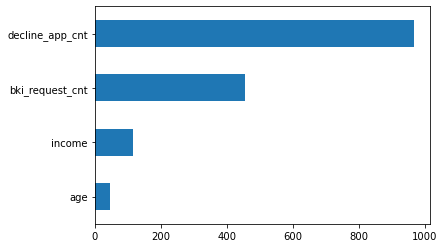

In [1039]:
train = data
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [1040]:
label_encoder = LabelEncoder()

for bin_col in bin_cols:
    data[bin_col] = label_encoder.fit_transform(data[bin_col])

data.education = data.education.astype('category').cat.codes

&lt;AxesSubplot:&gt;

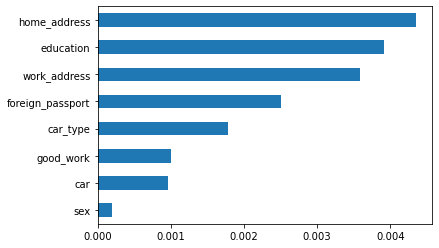

In [1041]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [1042]:
# X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
# data = pd.get_dummies(data, columns=['education'], drop_first=False)
data = pd.get_dummies(data, columns=cat_cols, drop_first=False)

In [1043]:
data[num_cols] = data[num_cols].apply(lambda x: np.log(x + 1))

In [1044]:
# Стандартизация числовых переменных

data[num_cols] = StandardScaler().fit_transform(data[num_cols].values)

In [1045]:
# Объединяем

X = data.drop('default', axis=1)
Y = data['default']

In [1046]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

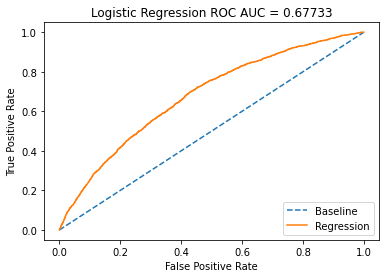

In [1047]:
C = 1
penalty = 'l2'
model = LogisticRegression(C=C, penalty=penalty)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [1048]:
print()

In [1049]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


In [1050]:
C

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])